In [325]:
from sklearn.decomposition import PCA

In [326]:
import pandas as pd
df = pd.read_csv('NewFeatures.csv')

In [327]:
df = df[df['distance_miles']!= 0]

In [328]:
only1and2 = df[df['Failure']!= 0]

In [329]:
only1and2 = only1and2.drop(['Unnamed: 0', 'date', 'platform_id', 'duration_mins', 'idle_duration_mins',
       'fuel_loss_gallons', 'dpf_regen_inhibited_duration_mins',
       'dpf_regen_not_inhibited_duration_mins',
       'dpf_regen_not_active_duration_mins', 'dpf_regen_active_duration_mins',
       'dpf_regen_needed_duration_mins',
       'dpf_regen_inhibit_switch_active_duration_mins', 'vehicle_serviced',
       'diagnostics_trouble_codes', 'dpf_regen_inhibit_switch_not_active_duration_mins', 'min_regen_inhibit_switch_not_active_per_mile'], axis = 1)

In [330]:
only1and2 = only1and2[['Failure', 'fuels_used_per_mile', 'miles_per_minutes', 'mins_idle_per_mile', 'percent_fuel_lost', 'fuel_lost_per_mile']]

In [331]:
onlyfail = only1and2[only1and2['Failure'] == 1]

In [332]:
onlynonfail = only1and2[only1and2['Failure'] == 2]

In [333]:
#Scale the data [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Nonfails
X_train = pd.DataFrame(scaler.fit_transform(onlynonfail), 
                              columns=onlynonfail.columns, 
                              index=onlynonfail.index)
# Random shuffle training data
X_train.sample(frac=1)

#Fails
X_test = pd.DataFrame(scaler.transform(onlyfail), 
                             columns=onlyfail.columns, 
                             index=onlyfail.index)

In [334]:
#PCA according to the tutorial

pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [335]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [336]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [337]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [338]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [339]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [340]:
import numpy as np
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [341]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [342]:
mean_distr = data_train.mean(axis=0)
mean_distr

array([ 2.26287495e-17, -9.42864564e-18])

In [343]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

In [344]:
threshold

3.0515068348992016

(0.0, 15)

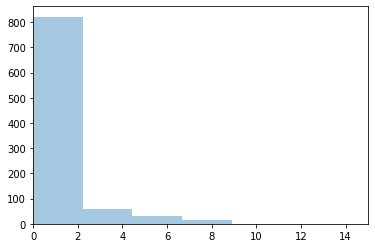

In [345]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.distplot(np.square(dist_train),
             bins = 30, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

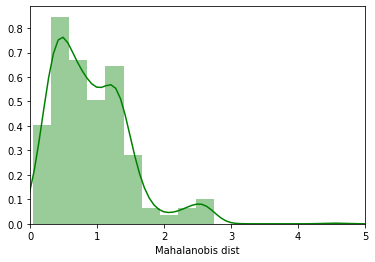

In [346]:
plt.figure()
sns.distplot(dist_train,
             bins = 30, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

Text(0.5, 0, 'Mahalanobis dist')

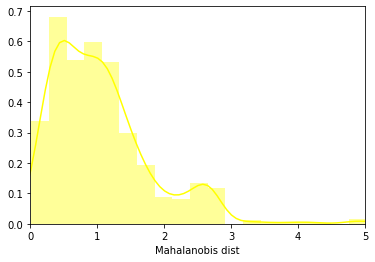

In [347]:
#Test Mahal
plt.figure()
sns.distplot(dist_test,
             bins = 30, 
             kde= True, 
            color = 'yellow');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [348]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
0,1.481721,3.051507,False
1,0.982086,3.051507,False
2,1.484951,3.051507,False
717,0.627522,3.051507,False
719,0.975698,3.051507,False


In [349]:
anomaly['Anomaly'].value_counts()

False    936
True      51
Name: Anomaly, dtype: int64

In [350]:
anomaly_train['Anomaly'].value_counts()

False    925
True      17
Name: Anomaly, dtype: int64

In [ ]:
#51/987 or 5.167% of the failure trucks were marked as anomalies

In [ ]:
#17/942 or 1.8047% of the nonfailure trucks were marked as anomalies.